In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [66]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()


def _normalize(img):
    """Normalize image using ImageNet mean and std"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return (img - mean) / std

def _denormalize(img):
    """Denormalize image from model input back to regular image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return img * std + mean

def _preprocess_image(img, size):
    """Convert numpy image to PyTorch tensor with proper normalization"""
    # Resize if needed
    if img.shape[0] != size or img.shape[1] != size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)

    # Convert to PyTorch tensor
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float()
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Normalize
    img_tensor = _normalize(img_tensor)
    return img_tensor

def _postprocess_image(tensor):
    """Convert PyTorch tensor back to numpy image"""
    # Denormalize
    tensor = _denormalize(tensor)

    # Convert to numpy array
    img = tensor.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    return img


def _min_max_normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size = size
        self.upscaling_steps = upscaling_steps
        self.upscaling_factor = upscaling_factor

        # Load pretrained VGG16 model
        self.model = models.vgg16(pretrained=True).eval()

        # Set model to non-trainable (equivalent to set_trainable(self.model, False))
        for param in self.model.parameters():
            param.requires_grad = False


    def visualize(self, layer_idx, filter_idx, lr=0.1, opt_steps=20, blur=None):
        sz = self.size

        # Generate random image (equivalent to the original code's random image)
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3))) / 255.0

        # Get the target layer
        target_layer = list(self.model.features.children())[layer_idx]

        # Register hook
        activations = SaveFeatures(target_layer)

        for _ in range(self.upscaling_steps):
            # Convert image to tensor with proper normalization
            img_var = _preprocess_image(img, sz)
            img_var.requires_grad = True

            # Setup optimizer
            optimizer = optim.Adam([img_var], lr=lr, weight_decay=1e-6)

            # Optimization loop
            for n in range(opt_steps):
                optimizer.zero_grad()
                self.model(img_var)

                # Target activation: maximize the mean activation of the specified filter
                loss = -activations.features[0, filter_idx].mean()

                loss.backward()
                optimizer.step()

            # Convert the optimized tensor back to numpy image
            img = _postprocess_image(img_var)
            self.output = img.copy()

            # Calculate new image size and scale up
            sz = int(self.upscaling_factor * sz)
            img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)

            # Apply blur if specified
            if blur is not None:
                img = cv2.blur(img, (blur, blur))

        self.save(layer_idx, filter_idx)
        activations.close()

    def show_image(self):
        img = _min_max_normalize(self.output)
        plt.imshow(img)
        plt.show()

    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))


In [38]:
layer = 28
filter = 265

visualizer = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)

# Visualize the 20th filter of the 10th layer
visualizer.visualize(layer_idx=layer, filter_idx=filter, lr=0.1, opt_steps=20, blur=2)

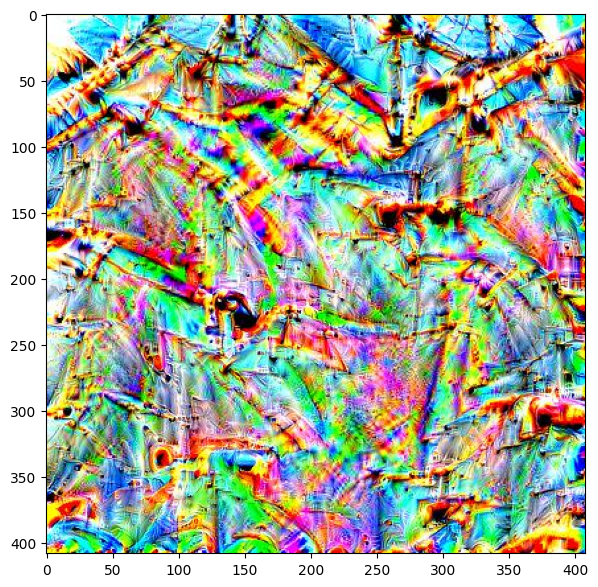

In [42]:
from PIL import Image
img = Image.open("layer_"+str(layer)+"_filter_"+str(filter)+".jpg")

plt.figure(figsize=(7,7))
plt.imshow(img)

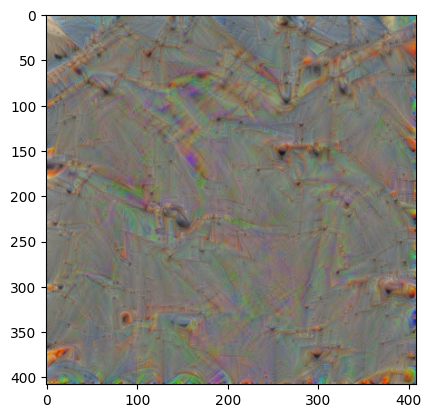

In [44]:
def denorm_img(image):
    img = image * np.array([0.229, 0.224, 0.225])[None, None, :] + np.array([0.485, 0.456, 0.406])[None, None, :]
    return (img - np.min(img)) / (np.max(img) - np.min(img))

plt.imshow(denorm_img(visualizer.output))

In [124]:
layer = 19
model = models.vgg16(pretrained=True).eval()
activations = SaveFeatures(list(model.features)[layer])

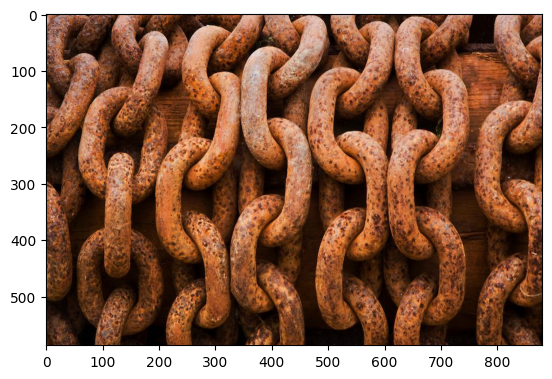

In [125]:
img = Image.open('./data/chains.jpg')

plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1650026..2.3982983].


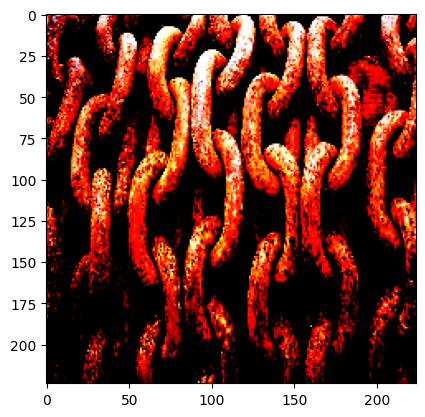

In [126]:
img_processed = _preprocess_image(np.array(img) / 255, 224)

plt.imshow(img_processed[0].permute(1, 2, 0))

In [127]:
o = model(img_processed)

In [128]:
mean_act = [activations.features[0,i].mean().item() for i in range(256)]
mean_act

[0.5406607389450073,
 1.0976914167404175,
 0.15719230473041534,
 1.525629997253418,
 0.2218978852033615,
 2.819157838821411,
 0.7056554555892944,
 4.599635601043701,
 0.1687854826450348,
 0.08349612355232239,
 0.37058258056640625,
 0.6645911335945129,
 0.1780404895544052,
 2.2031829357147217,
 1.024734377861023,
 1.193190097808838,
 7.587182998657227,
 0.08323729783296585,
 0.2717958688735962,
 1.6571227312088013,
 3.6942050457000732,
 1.3636611700057983,
 5.6090168952941895,
 0.08094092458486557,
 0.052084337919950485,
 0.00767929945141077,
 0.2942507863044739,
 7.697676658630371,
 1.5642675161361694,
 0.5366073250770569,
 1.894919753074646,
 0.9137855172157288,
 0.26405981183052063,
 2.332617998123169,
 0.01799600198864937,
 1.3748153448104858,
 1.4787890911102295,
 0.4653221368789673,
 2.2772369384765625,
 1.1352306604385376,
 2.139347791671753,
 0.9402130842208862,
 0.2816513478755951,
 0.8808448314666748,
 0.5275521874427795,
 0.19536863267421722,
 0.6888782978057861,
 7.117233753

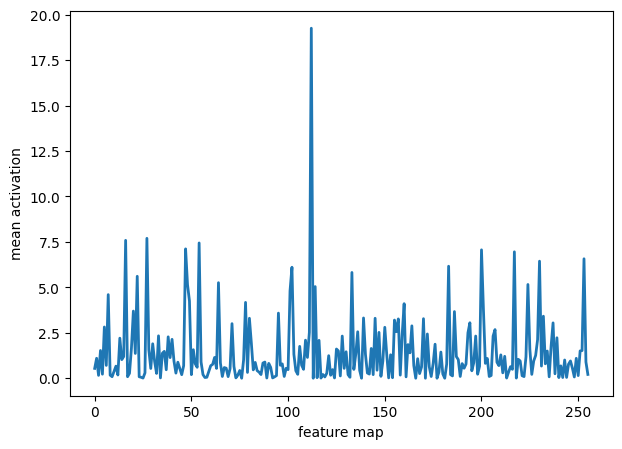

In [129]:
def plot_mean_act(mean_act):
    plt.figure(figsize=(7,5))
    act = plt.plot(mean_act,linewidth=2.)
    ax = act[0].axes
    ax.set_xlabel("feature map")
    ax.set_ylabel("mean activation")
    plt.show()

plot_mean_act(mean_act)

In [130]:
filter_idx = np.argmax(mean_act)

filter_idx

112

In [132]:
model.features[layer], layer

(Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 19)

In [133]:
filter = filter_idx

visualizer = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)

# Visualize the 20th filter of the 10th layer
visualizer.visualize(layer_idx=layer, filter_idx=filter, lr=0.1, opt_steps=20, blur=2)

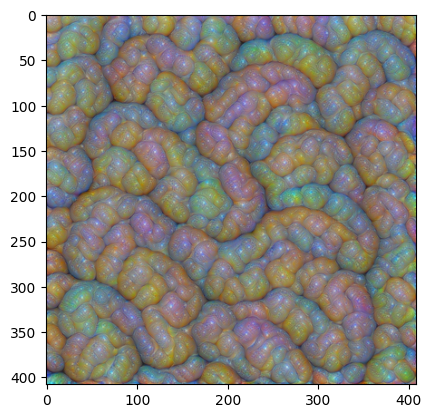

In [134]:
visualizer.show_image()

In [85]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [150]:
layer = 24
model = models.vgg16(pretrained=True).eval()
activations = SaveFeatures(list(model.features)[layer])

In [151]:
_ = model(img_processed)

In [152]:
mean_act = [activations.features[0,i].mean().item() for i in range(256)]
mean_act

[1.3444936275482178,
 0.7935136556625366,
 13.454171180725098,
 0.1556052267551422,
 0.1752602905035019,
 0.0,
 0.8871317505836487,
 0.09492849558591843,
 0.6597514748573303,
 0.6998255848884583,
 0.01357193011790514,
 5.6978325843811035,
 0.020481616258621216,
 9.94681453704834,
 0.0,
 1.4163146018981934,
 0.09625746309757233,
 0.03044510819017887,
 8.141111373901367,
 0.1263473927974701,
 0.20707182586193085,
 5.9995903968811035,
 0.01617996022105217,
 2.006239652633667,
 2.781942844390869,
 0.25826239585876465,
 1.0333199501037598,
 0.5227890610694885,
 0.11504913121461868,
 7.95888090133667,
 0.20890797674655914,
 0.3694460988044739,
 0.17864343523979187,
 0.23316600918769836,
 0.3830784857273102,
 0.6969655752182007,
 5.957222938537598,
 0.0,
 0.05855904147028923,
 1.7920349836349487,
 1.941744089126587,
 0.0027932485099881887,
 2.5065650939941406,
 0.0720304548740387,
 0.3999645411968231,
 0.32150179147720337,
 0.051932442933321,
 0.08881129324436188,
 0.41884079575538635,
 0.417

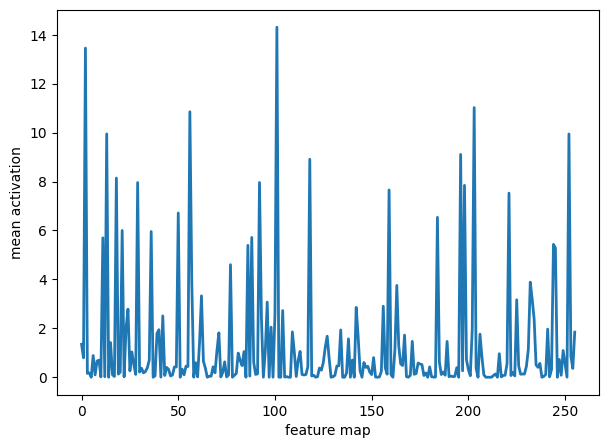

In [153]:
plot_mean_act(mean_act)

In [154]:
filter_idx = np.argmax(mean_act)

filter_idx, layer

(101, 24)

In [155]:
visualizer = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)

visualizer.visualize(layer_idx=layer, filter_idx=filter_idx, lr=0.1, opt_steps=20, blur=2)

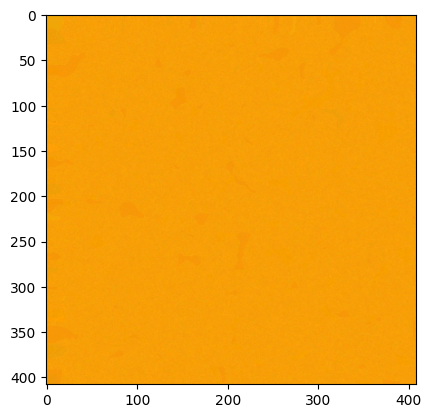

In [156]:
visualizer.show_image()